<a href="https://colab.research.google.com/github/ishaqmarashy/Digit-Recognizer-ML/blob/main/Digit_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
# Common imports
import sklearn
import pandas as pd
import numpy as np
import tensorflow as tf

# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [65]:
train = pd.read_csv( "./train.csv")
test = pd.read_csv("./test.csv")

In [66]:
print(train.info(),train.columns,"\n",train['label'].value_counts(),"\n",train['pixel0']) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785) 
 1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64 
 0        0
1        0
2        0
3        0
4        0
        ..
41995    0
41996    0
41997    0
41998    0
41999    0
Name: pixel0, Length: 42000, dtype: int64


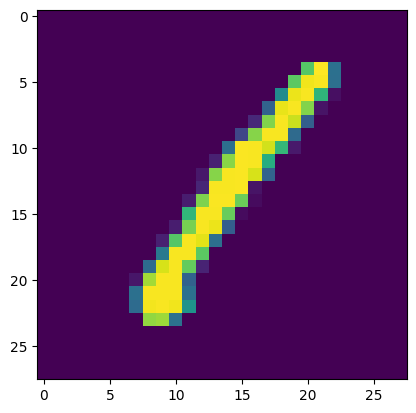

In [67]:
from keras.utils.np_utils import to_categorical 

y_train = to_categorical(train['label'], num_classes = 10)
X_train = train.drop('label',axis=1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)
plt.imshow(X_train[0][:,:,0])

In [68]:
mu = X_train.mean().astype(np.float32)
std = X_train.std().astype(np.float32)
X_train=(X_train-mu)/std
test=(test-mu)/std

In [69]:
from sklearn.model_selection import train_test_split

X = X_train
y = y_train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.30, random_state=42)

In [70]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
model = Sequential([
        Conv2D(32,(3,3), activation='relu',input_shape=(28,28,1)),
        BatchNormalization(),
        Conv2D(32,(6,6), activation='relu'),
        MaxPool2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
        ])
model.compile(Adam(), loss='categorical_crossentropy',metrics=['accuracy'])

In [71]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    samplewise_center=False, 
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,  
    vertical_flip=False)
datagen.fit(X_train)

epochs=29
batch_size = 64

train_data=datagen.flow(X_train,y_train, batch_size=batch_size)
validation_data=datagen.flow(X_train, y_train, batch_size=8)
histcb=model.fit(train_data, validation_data=validation_data,verbose = 2,steps_per_epoch=len(X_train) / batch_size, epochs=epochs)

Epoch 1/30
459/459 - 52s - loss: 0.4071 - accuracy: 0.8769 - val_loss: 0.1866 - val_accuracy: 0.9520 - 52s/epoch - 114ms/step
Epoch 2/30
459/459 - 47s - loss: 0.1273 - accuracy: 0.9600 - val_loss: 0.1001 - val_accuracy: 0.9686 - 47s/epoch - 103ms/step
Epoch 3/30
459/459 - 45s - loss: 0.0991 - accuracy: 0.9688 - val_loss: 0.0780 - val_accuracy: 0.9754 - 45s/epoch - 99ms/step
Epoch 4/30
459/459 - 46s - loss: 0.0785 - accuracy: 0.9746 - val_loss: 0.0628 - val_accuracy: 0.9805 - 46s/epoch - 99ms/step
Epoch 5/30
459/459 - 45s - loss: 0.0726 - accuracy: 0.9772 - val_loss: 0.0834 - val_accuracy: 0.9745 - 45s/epoch - 97ms/step
Epoch 6/30
459/459 - 45s - loss: 0.0678 - accuracy: 0.9785 - val_loss: 0.0706 - val_accuracy: 0.9780 - 45s/epoch - 97ms/step
Epoch 7/30
459/459 - 45s - loss: 0.0652 - accuracy: 0.9803 - val_loss: 0.0560 - val_accuracy: 0.9826 - 45s/epoch - 97ms/step
Epoch 8/30
459/459 - 45s - loss: 0.0584 - accuracy: 0.9810 - val_loss: 0.0552 - val_accuracy: 0.9819 - 45s/epoch - 98ms/ste

In [72]:
y_pred=model.predict( X_train, batch_size=batch_size, verbose=0)
y_pred=np.argmax(y_pred,axis = 1) 
y_pred

array([4, 0, 9, ..., 2, 6, 0], dtype=int64)